## Calibration of model parameters (BLACK and SCHOLES, MERTON)
The **Implied Volatility** is that value $\\sigma$ that must be inserted into the Black-Scholes (BS) formula in order to retrieve the option price quoted in the market:
$$ BS(S, K, T, r, \sigma) = P  $$
where $S$ is the underlying spot price, $K$ is the strike, $T$ time to maturity, $r$ risk-free interest rate and $P$ the option price quoted in the market. All these quantities are **observable**.


In [2]:
from functions.MERTONpricer import Merton_pricer
from functions.BSpricer import BS_pricer
from functions.KOUpricer import Kou_pricer

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy as scp
import scipy.stats as ss
import scipy.optimize as scpo


Let's retrieve the historic prices for european call and put options starting from 2016-01-20 and expiring 1 year later.

In [16]:
df_call = pd.read_csv('data/options_spx_call_2016.csv')
df_put = pd.read_csv('data/options_spx_put_2016.csv')

df_call['C_Midpoint'] = abs(df_call['C_BID'] + df_call['C_ASK']) / 2
df_put['P_Midpoint'] = abs(df_put['P_BID'] + df_put['P_ASK']) / 2
df_call['C_Spread'] = df_call['C_BID'] - df_call['C_ASK']
df_put['P_Spread'] = df_put['P_BID'] - df_put['P_ASK']

q = 0       # dividend yield
r = 0.1     # risk-free interest rate
sigma = 0.5 #volatility (variance of diffusion process)
S0 = df_call.iloc[0]['UNDERLYING_LAST']
T = 1
strikes = np.arange(50,151,5)
call_strikes = df_call['STRIKE']    # array of K
put_strikes = df_put['STRIKE']
exercise = 'european'

call_prices = df_call['C_Midpoint']
put_prices = df_put['P_Midpoint']

Let's initialize an object of class BS_pricer which is able to find the theoretical price of the options, given the parameters.

In [5]:
BS = BS_pricer(S0=S0, r=r, q = q, sigma=sigma, ttm=T, exercise=exercise, K=None)
Merton = Merton_pricer(S0=S0, K=None, ttm=T, r=r, q = q, sigma=sigma, lambd=0.8, meanJ=-0.1, stdJ=0.2, exercise=exercise)
Kou = Kou_pricer(S0=S0, K=None, ttm=T, r=r, sigma=sigma, lambd=1, p=0.4, eta1=10, eta2=5, exercise=exercise)

call_th_prices = pd.DataFrame(columns=['BlackScholes', 'Merton', 'Kou'])

for i, K in enumerate(call_strikes):
    bs = BS.closed_formula_call(K)
    mert = Merton.closed_formula_call(K)
    kou = Kou.closed_formula_call(K)
    call_th_prices.loc[i] = [bs, mert, kou]

print(f'Theoretical call options prices:')
print(call_th_prices)


Theoretical call options prices:
    BlackScholes      Merton         Kou
0     519.267776  540.514601  545.888779
1     506.924480  528.456356  533.846489
2     494.841442  516.641882  522.044610
3     483.015579  505.068189  510.480268
4     471.443681  493.732193  499.150498
5     460.122426  482.630729  488.052252
6     449.048389  471.760562  477.182409
7     438.218057  461.118388  466.537785
8     427.627837  450.700855  456.115137
9     417.274071  440.504560  445.911177
10    407.153041  430.526062  435.922576
11    397.260982  420.761891  426.145970
12    387.594089  411.208549  416.577970
13    378.148525  401.862523  407.215165


PUT PRICES:

In [7]:
put_th_prices = pd.DataFrame(columns=['BlackScholes', 'Merton', 'Kou'])

for i, K in enumerate(put_strikes):
    bs = BS.closed_formula_put(K)
    mert = Merton.closed_formula_put(K)
    kou = Kou.closed_formula_put(K)
    put_th_prices.loc[i] = [bs, mert, kou]

print(f'Theoretical put options prices:')
print(put_th_prices)

Theoretical put options prices:
    BlackScholes      Merton         Kou
0     198.011387  219.258212  224.632390
1     208.289026  229.820902  235.211035
2     218.826923  240.627364  246.030091
3     229.621996  251.674606  257.086685
4     240.671034  262.959545  268.377850
5     251.970714  274.479017  279.900540
6     263.517612  286.229785  291.651633
7     275.308215  298.208547  303.627943
8     287.338931  310.411949  315.826231
9     299.606100  322.836589  328.243207
10    312.106006  335.479027  340.875541
11    324.834882  348.335792  353.719870
12    337.788925  361.403385  366.772806
13    350.964297  374.678294  380.030937


In [12]:
def implied_volatility(price, S, strike, t, rate, q, type_o, method, disp=True ):
    """ Returns Implied volatility
        methods:  fsolve (default) or brent
    """

    def obj_fun(vol):
        return BS.BlackScholes(type_o=type_o, S0=S, K=strike, ttm=t, r=rate, q=q, sigma=vol) - price

    def vega(vol):
        return BS.vega(S, strike, rate, q, vol, t)

    if method == 'brent':
        x, res = scpo.brentq(obj_fun, a=1e-15, b=500, full_output=True)
        if res.converged:
            return x

    if method =='fsolve':
        #X0 = [0.03, 0.08, 0.1, 0.15, 0.2, 0.3, 0.5, 1, 2]   # set of
        X0 = [0.1, 0.5, 1, 3]
        #initial guess points for imp.vol.
        for x_0 in X0:
            x, _, solved, _ = scpo.fsolve(obj_fun, x_0, full_output=True, xtol=1e-8)
            if solved == 1:
                return x[0]

    if method == 'newton':
        guess = 0.5
        result = scpo.newton(obj_fun, guess, vega, tol=1e-4)
        return result


    if disp:
        return -1

Let's now compute the implied volatilities from the true market prices *call_prices*.

In [13]:
IV_BS = []; IV_M = []; IV_K = []

for i in range(len(call_prices)):
    IV_BS.append(implied_volatility(call_th_prices['BlackScholes'].values[i], S=S0, strike=call_strikes[i], t=T, rate=r,q=q, type_o='call', method='newton') )
    IV_M.append(implied_volatility(call_th_prices['Merton'].values[i], S=S0, strike = call_strikes[i], t=T, rate=r, q=q,  type_o='call', method='newton'))
    IV_K.append(implied_volatility(call_th_prices['Kou'].values[i], S=S0, strike = call_strikes[i], t=T, rate=r, q=q,  type_o='call', method='newton'))

imp_vol_call = pd.DataFrame(columns=['BlackScholes', 'Merton', 'Kou'])
imp_vol_call['BlackScholes'] = IV_BS
imp_vol_call['Merton'] = IV_M
imp_vol_call['Kou'] = IV_K

print(f'Implied volatilities found by each model for call options:\n{imp_vol_call}')

Implied volatilities found by each model for call options:
    BlackScholes    Merton       Kou
0            0.5  0.534828  0.543615
1            0.5  0.534692  0.543361
2            0.5  0.534559  0.543115
3            0.5  0.534430  0.542877
4            0.5  0.534304  0.542646
5            0.5  0.534182  0.542421
6            0.5  0.534063  0.542204
7            0.5  0.533947  0.541993
8            0.5  0.533834  0.541788
9            0.5  0.533724  0.541589
10           0.5  0.533616  0.541396
11           0.5  0.533512  0.541208
12           0.5  0.533410  0.541026
13           0.5  0.533310  0.540848


In [17]:
IV_BS = []; IV_M = []; IV_K = []

for i in range(len(put_prices)):
    IV_BS.append(implied_volatility(put_th_prices['BlackScholes'].values[i], S=S0, strike=put_strikes[i], t=T, rate=r, q=q, type_o='put', method='newton' ) )
    IV_M.append(implied_volatility(put_th_prices['Merton'].values[i], S=S0, strike = put_strikes[i], t=T, rate=r, q=q, type_o='put', method='fsolve'))
    IV_K.append(implied_volatility(put_th_prices['Kou'].values[i], S=S0, strike = put_strikes[i], t=T, rate=r, q=q, type_o='put', method='fsolve'))

imp_vol_put = pd.DataFrame(columns=['BlackScholes', 'Merton', 'Kou'])
imp_vol_put['BlackScholes'] = IV_BS
imp_vol_put['Merton'] = IV_M
imp_vol_put['Kou'] = IV_K

print(f'Implied volatilities found by each model for put options:\n {imp_vol_put}')

Implied volatilities found by each model for put options:
     BlackScholes    Merton       Kou
0            0.5  0.534828  0.543615
1            0.5  0.534692  0.543361
2            0.5  0.534559  0.543115
3            0.5  0.534430  0.542877
4            0.5  0.534304  0.542646
5            0.5  0.534182  0.542421
6            0.5  0.534063  0.542204
7            0.5  0.533947  0.541993
8            0.5  0.533834  0.541788
9            0.5  0.533724  0.541589
10           0.5  0.533616  0.541396
11           0.5  0.533512  0.541208
12           0.5  0.533410  0.541026
13           0.5  0.533310  0.540848


Plot of the implied volatilities with respect to the strike price.

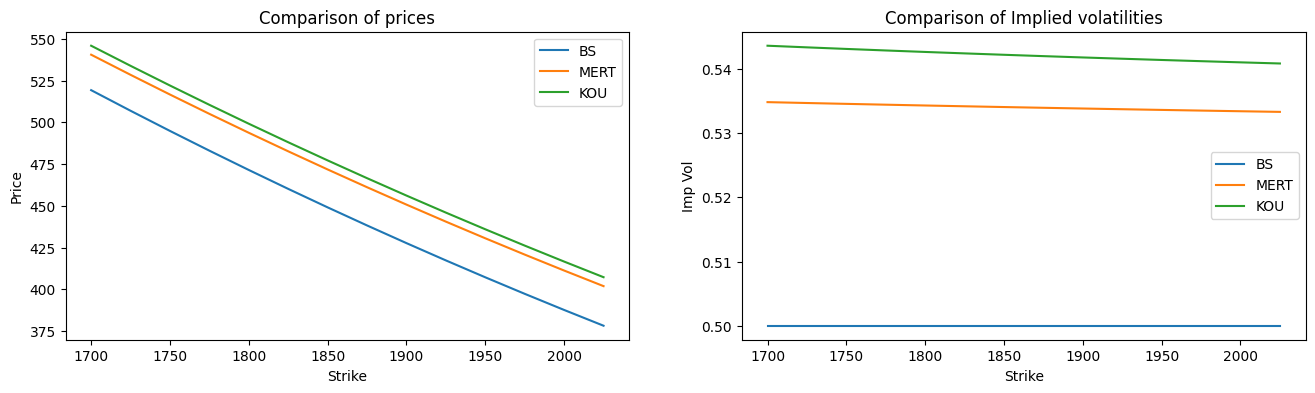

In [18]:
fig = plt.figure(figsize=(16,4))
ax1 = fig.add_subplot(121); ax2 = fig.add_subplot(122)

ax1.plot(call_strikes, call_th_prices['BlackScholes'], label="BS"); ax1.plot(call_strikes, call_th_prices['Merton'], label="MERT")
ax1.plot(call_strikes, call_th_prices['Kou'], label="KOU")
ax1.set_title("Comparison of prices"); ax1.set_xlabel("Strike"); ax1.set_ylabel("Price")

ax2.plot(call_strikes, imp_vol_call['BlackScholes'], label="BS"); ax2.plot(call_strikes, imp_vol_call['Merton'], label="MERT")
ax2.plot(call_strikes, imp_vol_call['Kou'], label="KOU")
ax2.set_title("Comparison of Implied volatilities"); ax2.set_xlabel("Strike"); ax2.set_ylabel("Imp Vol")

ax1.legend(); ax2.legend(); plt.show()

## Calibration of Merton Jump Diffusion parameters
First we'll initialize a starting point in the array $x0 = [σ, λ, m, v]$
and we set bounds for the 4 parameters. Then we use the method
1. **curve_fit** of scipy.optimize. It uses the trf method when the parameters are bounded and the Levemberg-Marquadt method for unbounded parameters.

In [21]:
x0 = [0.15, 1, 0.1, 1] # initial guess: [σ, λ, m, v]
bounds = ( [0, 0, -10, 0.1], [np.inf, np.inf, 10, 5] )

def f_Mert(x, sigma, lambd, meanJ, stdJ):
    Mert = Merton_pricer(S0=S0, K=x, ttm=T, r=r, q=0, sigma=sigma, lambd=lambd, meanJ=meanJ, stdJ=stdJ, exercise=exercise)
    return Mert.closed_formula_call(x)
#

- Method 1. curve_fit of scipy.optimize. It uses the trf method when the parameters are bounded and the Levemberg-Marquadt method for unbounded parameters.

In [22]:
res1 = scpo.curve_fit(f_Mert, call_strikes, call_prices, p0=x0, bounds=bounds)

sigt = round(res1[0][0],5)
lambdt = round(res1[0][1],2)
mt = round(res1[0][2],2)
vt = round(res1[0][3],5)

print('METHOD 1: CURVE_FIT (trf)')
print('> Calibrated Volatlity [σ] = ', sigt)
print('> Calibrated Jump intensity [λ] = ', lambdt)
print('> Calibrated Jump Mean = ', mt)
print('> Calibrated Jump St. dev.  = ', vt)

METHOD 1: CURVE_FIT (trf)
> Calibrated Volatlity [σ] =  0.01351
> Calibrated Jump intensity [λ] =  0.11
> Calibrated Jump Mean =  0.28
> Calibrated Jump St. dev.  =  0.10005


In [23]:
res1_2 = scpo.curve_fit(f_Mert, call_strikes, call_prices, p0=x0)

sigt2 = round(res1_2[0][0],5)
lambdt2 = round(res1_2[0][1],2)
mt2 = round(res1_2[0][2],2)
vt2 = round(res1_2[0][3],5)

print('METHOD 1.2: CURVE_FIT (Levemberg-Marquadt, no bounds)')
print('> Calibrated Volatlity [σ] = ', sigt2)
print('> Calibrated Jump intensity [λ] = ', lambdt2)
print('> Calibrated Jump Mean = ', mt2)
print('> Calibrated Jump St. dev.  = ', vt2)

C:\Users\ornel\OneDrive\Desktop\TESI\PythonProjects\Margin-Loans-Pricing\python-modules\functions\MERTONpricer.py:54: RuntimeWarning: overflow encountered in exp
  V += (np.exp(-mean * self.lambd * self.ttm) * (mean * self.lambd * self.ttm) ** k) / k_fact * \
C:\Users\ornel\OneDrive\Desktop\TESI\PythonProjects\Margin-Loans-Pricing\python-modules\functions\MERTONpricer.py:54: RuntimeWarning: overflow encountered in scalar power
  V += (np.exp(-mean * self.lambd * self.ttm) * (mean * self.lambd * self.ttm) ** k) / k_fact * \


RuntimeError: Optimal parameters not found: Number of calls to function has reached maxfev = 1000.

- Method 2. minimize(method=’SLSQP’)

In [26]:
x0 = [0.2, 0.5, -0.1, 1] # initial guess: [σ, λ, m, v]
bounds = [(0.01, 3), (0, np.inf), (-5, 5),  (0, 5)]

# Define the objective function
def obj_function(x, strikes, prices):
    sigm, lamb, mean, std = x
    Mert = Merton_pricer(S0=S0, K=strikes, ttm=T, r=r, q=0, sigma=sigm, lambd=lamb, meanJ=mean, stdJ=std, exercise=exercise)
    return np.sum((Mert.closed_formula_call(K) - prices) ** 2)

additional_args = (call_strikes, call_prices)

res2 = scpo.minimize(obj_function, x0, args=additional_args,  method='SLSQP', bounds=bounds, tol=1e-20)

print(res2)
sigt, lambdt, mt, vt = res2.x

# Print the results
print('> METHOD 2: MINIMIZE (SLSQP)')
print('Calibrated Volatility [σ] =', round(sigt, 5))
print('Calibrated Jump Intensity [λ] =', round(lambdt, 2))
print('Calibrated Jump Mean [m] =', round(mt, 2))
print('Calibrated Jump St. dev. [v] =', round(vt, 2))

 message: Optimization terminated successfully
 success: True
  status: 0
     fun: 2066060.211499446
       x: [ 2.000e-01  5.000e-01 -1.000e-01  1.000e+00]
     nit: 5
     jac: [ 2.671e+06  6.795e+06  4.971e+06  8.124e+06]
    nfev: 5
    njev: 1
> METHOD 2: MINIMIZE (SLSQP)
Calibrated Volatility [σ] = 0.2
Calibrated Jump Intensity [λ] = 0.5
Calibrated Jump Mean [m] = -0.1
Calibrated Jump St. dev. [v] = 1.0


## Calibration of Kou Jump Diffusion parameters